# 1. San Francisco's Southern district has the highest number of thefts.


## Overview

Based on the dataset related to San Fransisco ("SF") incidents during summer 2014 and through some manipulations and visualisations in R, I try to understand the following: 
(i) what and where are the most common type of crime(s) in SF
(ii) other interesting patterns and analysis e.g. resolution rates of crimes

My approach is done a top-down manner: I get an overview of crime in SF and then drill down into what I think are the interesting data and patterns.
##  


In [1]:
remove(list = ls())
options("scipen"=10, "digits"=10)
options(warn=-1)

all = read.csv('sanfrancisco_incidents_summer_2014.csv', header = TRUE, sep=',' , 
               stringsAsFactors = default.stringsAsFactors())

# format the data
library(chron)
all$Descript = as.character(all$Descript)
all$Date = as.character(all$Date)
all$Time = as.character(all$Time)
all$Address = as.character(all$Address)
all$DateTime = as.chron( paste(all$Date, all$Time), '%m/%d/%Y %H:%M')

# remove unwanted columns
all = all[, !(colnames(all) %in% c('Date', 'Time', 'PdId', 'Location'))]


##  
To get a quick overview of SF crime, I plotted the occurences of crime by type of crime across the various SF districts in a grid layout. I also categorised the crime by whether it is resolved or not. A crime is considered resolved if its resolution status is not 'None'.
##  


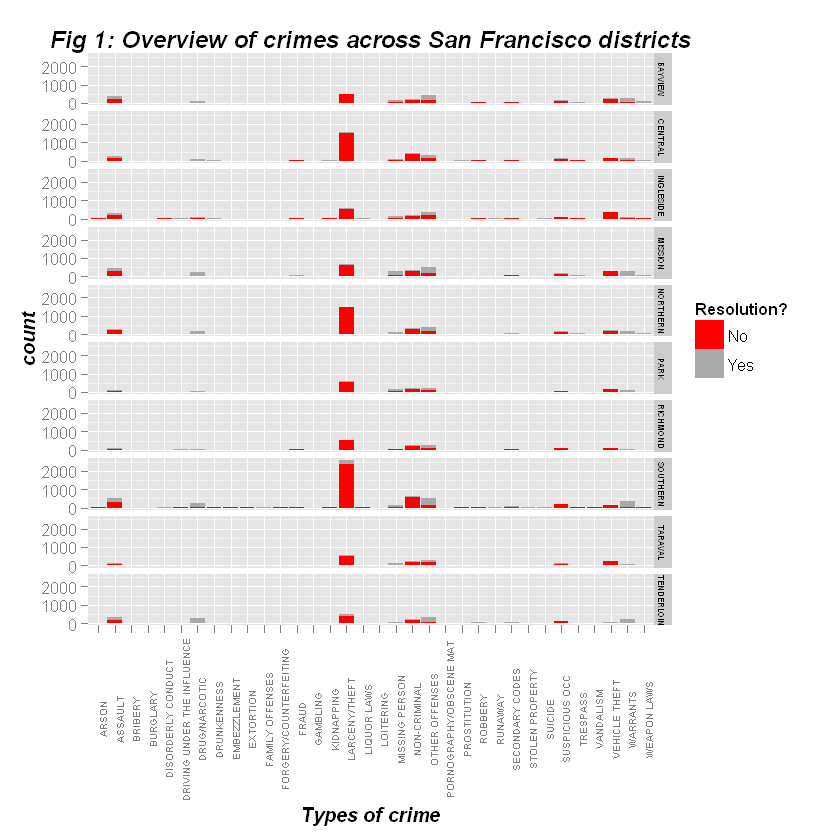

In [2]:
library(ggplot2)

ggplot(all, aes(Category)) + 
  geom_bar(aes(fill = Resolution != 'NONE')) +   
  facet_grid(PdDistrict ~ .) +
  theme(axis.text.x = element_text(angle=90, size = 6)) +
  scale_fill_manual(name='Resolution?', breaks=c(FALSE,TRUE), labels=c('No','Yes'), values=c('red','dark gray')) +
  labs(title = "Fig 1: Overview of crimes across San Francisco districts", x = 'Types of crime' ) +
  theme(strip.text.y = element_text(size = 5), title = element_text(face = "bold.italic", color = "black")  )

##  
Figure 1 above shows that (i) larceny or theft is by far the most common crime in SF and (ii) Southern district has the highest number of theft cases as compared to the other districts.

Visually, the red bars are the unresolved crimes and the grey bars are the resolved crimes. We can observe that theft cases are mainly unresolved while drug, other offences and warrants have higher proportions of resolution.

At this point, some questions popped up in my mind: why does Southern have the highest number of thefts? Is it due to the district's effectiveness in enforcement or combatting crime as measured (simply) by resolution rate? 

Next I take a look at the crime resolution rates across the SF districts.
##  


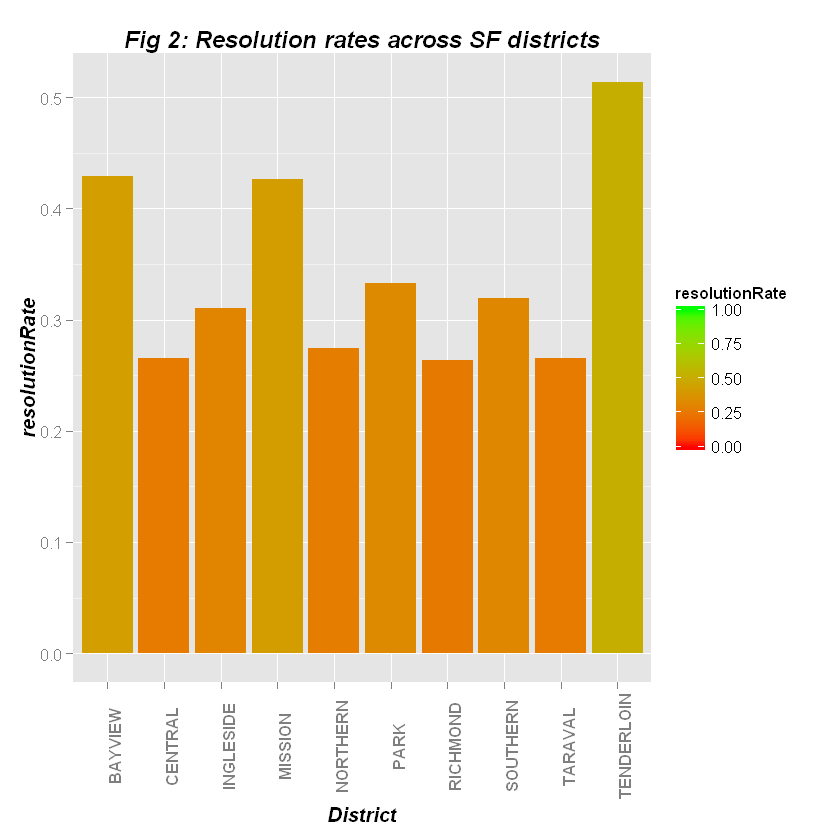

In [3]:
# helper function to compute resolution rates
computeRR = function(x) {
  result  = sum(x != 'NONE') / length(x)
  return (result)
}

library(plyr)
district.rr = ddply(all, c('PdDistrict'), summarise, resolutionRate=computeRR(Resolution) )
tmp = district.rr

ggplot(tmp, aes(x=PdDistrict, y=resolutionRate, fill=resolutionRate)) + geom_bar(stat = "identity") +
  scale_fill_gradient(limits=c(0, 1), low='red', high='green') +
  theme(axis.text.x = element_text(angle=90, face='bold'), title = element_text(face = "bold.italic", color = "black")) +
  labs(title = "Fig 2: Resolution rates across SF districts", x = "District" ) 

# 2. And surprisingly Southern has a decent record of resolving crimes, especially thefts.


Figure 2 above shows that Southern's crime resolution rate is actually pretty decent - it is definitely not the lowest and it achieved more than 30% resolution rate. Please note that this is across all types of crimes.

To be more precise, I analysed the Southern's record in resolving, particularly, theft cases. In the code below, I ran a bootstrap of 10,000 resamples and found that Southern's theft resolution rate of 7.61% exceeds the 99% of the upper confidence interval of the resampled distribution. 
##  


In [4]:
attach(all)
south = all[PdDistrict=='SOUTHERN',]
south.theft = all[PdDistrict=='SOUTHERN' & Category=='LARCENY/THEFT',]

# compare resolution rates
numSamples = 10000 ; stats = NULL ; mySample = all[all$Category=='LARCENY/THEFT','Resolution']; n = nrow(south.theft)

for (i in 1:numSamples) {  
  a = sample(mySample, n, replace=TRUE )  # pick random theft cases of number  same as southern  
  stats[i] = computeRR(a)
}

computeRR(south.theft$Resolution)

# And obtaining the distribution with confidence intervals
quantile(stats, probs = c(0,0.01,0.99,1), na.rm=TRUE )

[1] 0.07611241218

0%            1%           99%          100% 
0.04098360656 0.04605776737 0.06752537080 0.07377049180

##  
Lastly, I decided to visually compare the resolution rates across types of crimes and districts.

As there are more than 30 types of crime, I decided to select the top 15 most common crimes and subsumed the rest under OTHERS type e.g. theft and assault will remain identified as major crimes while vandalism, extortion, bribery etc will be classified as OTHERS. This should result in a simpler and hopefully, more aesthetical visualization for you.
##  


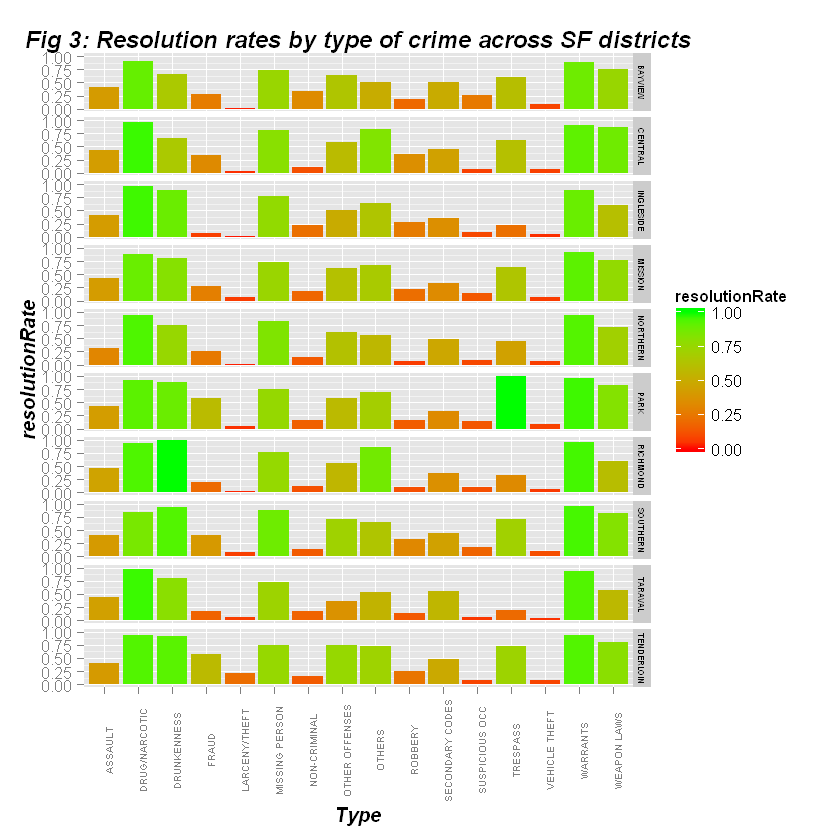

In [5]:
# too messy to display resolution rate of all categories of crime ...
district.cat.rr = ddply(all, c('PdDistrict', 'Category'), summarise, resolutionRate=computeRR(Resolution) )
tmp = district.cat.rr
#ggplot(tmp, aes(x=Category, y=resolutionRate)) + geom_bar(stat = "identity") +
#  facet_grid(PdDistrict ~ .) +
#  theme(axis.text.x = element_text(angle=90, face='bold'))

# so we choose a top x categories of crime and classify the rest as OTHERS
tmp = count(all, .(Category))
tmp = arrange(tmp, desc(freq))
topx = 15
others = as.character(tmp[ (topx+1):nrow(tmp) ,1])
all$Type = as.factor( ifelse(as.character(all$Category) %in% others, 'OTHERS', as.character(all$Category) ))

library(plyr)
rr = ddply(all, c('PdDistrict', 'Type'), summarise, resolutionRate=computeRR(Resolution) )
tmp = rr
ggplot(tmp, aes(x=Type, y=resolutionRate, fill=resolutionRate)) + geom_bar(stat = "identity") +
  facet_grid(PdDistrict ~ .) +   
  scale_fill_gradient(limits=c(0, 1), low='red', high='green') +
  theme(axis.text.x = element_text(angle=90, size=6), strip.text.y = element_text(size = 5), title = element_text(face = "bold.italic", color = "black")) +
  labs(title = "Fig 3: Resolution rates by type of crime across SF districts") 

# 3. Crime resolution rates are quite consistent across SF districts.


Figure 3 above suggests most of the crimes' resolution rates are pretty consistent across the districts, with some interesting exceptions such as trespassing in Park district and fraud in ingleside.

Figure 3 also indicates crimes such as theft, robbery, suspicious occ, vehicle thefts are at the lower end of resolution rates while drug/narcotics, drunkenness and missing person crimes have higher resolution rates.


## The end - Thank you for your time in reading and reviewing this post.